# Flight Data Analysis - Airbus

In [1]:
#!pip install lifelines

In [2]:
from __future__ import division

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy

from scipy.stats import exponweib, lognorm
from scipy.stats import distributions

from numpy import arange, dot, exp, newaxis, pi, tensordot
from scipy.special import gamma, kv
from scipy.stats import rv_continuous
from scipy.stats import norm

import warnings

## I. Data Set

In [3]:
# import data by using colab

# import sys
# sys.path.append('/content/drive/My Drive/Hoc/Projet5A/')
# import vect
# from vect import varange, vectorize

# from google.colab import drive
# drive.mount('/content/drive/')
# file_location = '/content/drive/My Drive/Hoc/Projet5A/INSA-Airbus FHS - Dataset_ter.xlsx'

In [4]:
# by using notebook

file_location = "./Dataset_ter.xlsx"

##### Data preprocessing :

In [5]:
def preprocessing(file_location):
# Import data
    Removals = pd.read_excel(file_location, sheet_name='Removals')
    SNlist = pd.read_excel(file_location, sheet_name='SN list')
    airlines = pd.read_excel(file_location, sheet_name='Airlines')

# Combining Removals and SNlist :
    fail_and_not = SNlist.copy()
    fail_and_not['failed'] = False
    fail_and_not[fail_and_not['Current SN Status Description']=='In Outside Repair']=True
    fail_and_not = fail_and_not.drop(['Description','Current SN Status Description','Since New Date'], axis = 1)
    fail_and_not = fail_and_not.rename(columns={"Part Number": "PN", "Serial Number": "SN", "Hour ageing Since Installation": "TSI", "Hour ageing Since New": "TSN"})
    dic_PN = {"C":"C","C-new":"C-new","A":"A","B":"B"}
    fail_and_not["PN"] = fail_and_not.PN.map(dic_PN)

    fail = Removals[Removals['Maintenance Type']=='Unscheduled']
    fail = fail.drop(['Removal date','Description','Maintenance Type'], axis=1)
    fail = fail.rename(columns={"P/N": "PN", "S/N": "SN", "TSI (Flight Hours) at removal": "TSI", "TSN (Flight Hours) at Removal": "TSN", "Customer":"Company"})
    fail['failed'] = True
    fail['PN'] = fail.PN.map(dic_PN)

    all_SN = pd.unique(fail_and_not['SN'])
    SN_Removals = pd.unique(fail['SN'])

    combined = pd.concat([fail,fail_and_not], ignore_index=True)
    combined = combined.drop_duplicates(subset=['SN','PN','TSN'], keep='last')
    
# Data errors treatment
    combined['TSI']=combined['TSI'].replace(np.nan, 0.0)
    combined['TSN']=combined['TSN'].replace(np.nan, 0.0)
    combined['Company']=combined['Company'].replace('1', 1)
    combined['Company']=combined['Company'].replace('3', 3)
    combined = combined[combined['TSN']!=0]
    
    return combined, airlines

In [6]:
combined, airlines = preprocessing(file_location)

types = pd.unique(combined["PN"])
types = types[np.logical_not(pd.isnull(types))]
print("Unit types :",types)
combined.head()

Unit types : ['C' 'B' 'A' 'C-new']


,Company,PN,SN,TSI,TSN,failed
0,3,C,15323054356,5819,5819,True
1,3,C,15323057041,5819,5819,True
2,3,C,15323072973,3036,3036,True
3,3,C,15323053425,5614,5614,True
4,3,C,15323058236,5614,5614,True


In [7]:
print(len(set(combined['SN'])),'/',len(combined), 'distinct SN.')

6005 / 7758 distinct SN.


## II. Data Analysis

In [8]:
data = combined.copy()
alpha = 0.05 # coefficient related to confidence levels

In [9]:
data_types = {}
for typ in types:
    data_types[typ] = data[data['PN']==typ]

In [10]:
def time_sticker(data_type): 
    T = data_type.TSI.to_numpy(dtype="float")
    d = np.array([1 if f == True else 0 for f in data_type.failed])
    return T,d

### 1. Nelson-Aalen and Kaplan-Meier estimators

We first consider the Nelson-Aalen estimator and the Kaplan-Meier estimator which will be used to compare with the model we apply for data in each cases.

(Note that we need to install the "lifelines" package for Python).

In [11]:
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

def NAF(typ,df=data_types): # Nelson_Aalen model
    data_type = df[typ]
    T,d=time_sticker(data_type)
    label = "NA-estimator of type " + typ
    return NelsonAalenFitter().fit(T,d,alpha=alpha,label=label)

def KMF(typ,df=data_types): # Kaplan_meier model
    data_type = df[typ]
    T,d=time_sticker(data_type)
    label = "KM-estimator of type " + typ
    return KaplanMeierFitter().fit(T,d,alpha=alpha,label=label)

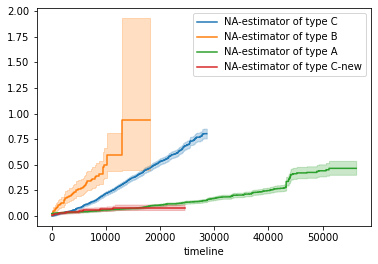

In [12]:
for typ in types:
    NAF(typ).plot(ci_show=True)

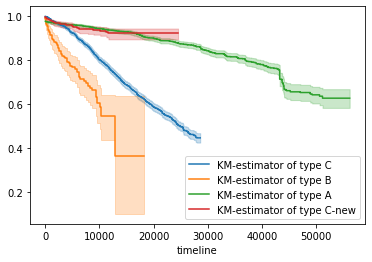

In [13]:
for typ in types:
    KMF(typ).plot(ci_show=True)

### 2. Parametric models

Find best parametric model

In [14]:
from lifelines.utils import find_best_parametric_model

def best_parametric_model(typ,df=data_types): # find the best parametric model which bases in AIC (or BIC as we can change scoring_method="BIC") method.
    data_type = df[typ]
    T,d=time_sticker(data_type)
    T[T==0]=1e-6 # Avoid divising by zero.
    tau=1-sum(d)/len(d)
    if tau>0.9:
        warnings.warn("There are more 90% censored data in type {} data. The applied model might not be correct!".format(str(typ)))
    best_model = find_best_parametric_model(T, d, scoring_method="AIC")[0]
    return best_model

Plotting best parametric model and KM-estimator:

In [15]:
def R_plot(typ): # We visualize if the best parametric model can fit the data of type "typ"
    m = best_parametric_model(typ)
    m.survival_function_.plot()
    KMF(typ).plot()
    plt.ylabel('Reliability function')
    plt.xlabel('Timeline')
    plt.title('Type ' + typ + ' data')

<ipython-input-14-1c412288dc8f>:9: UserWarning: There are more 90% censored data in type C-new data. The applied model might not be correct!
  warnings.warn("There are more 90% censored data in type {} data. The applied model might not be correct!".format(str(typ)))


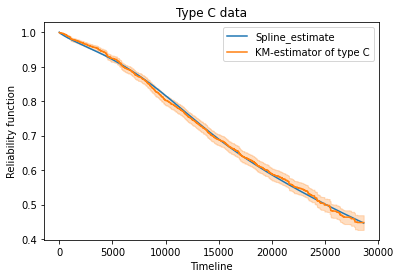

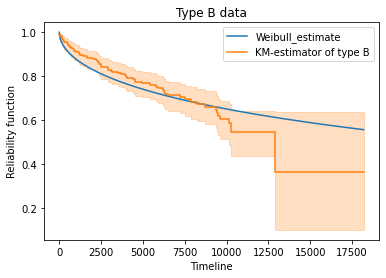

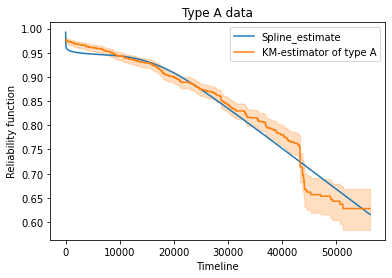

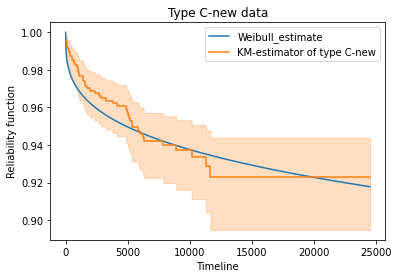

In [16]:
for typ in types:
    R_plot(typ)

## III. Simulation and stock optimization 

In [17]:
list_company = pd.unique(airlines["Company"])
list_company = list_company[np.logical_not(pd.isnull(list_company))]
print("List of companies :",list_company)
airlines

List of companies : [1 2 3 4 5 6]


,Company,Number of aircraft,FH per aircraft per month,End of contract
0,1,6,415,2024-12-01
1,2,2,310,2030-12-01
2,3,12,350,2026-12-01
3,4,5,240,2023-12-01
4,5,19,375,2026-12-01
5,6,6,350,2027-12-01


Simulation from parametric law

The idea is: for each individual SN, we simulate the number of time it will fail till the end of contract, then for large number of SN, we repeat that simulation for each individual to calculate the sum.

Simulation from kaplan Meier

In [18]:
def inverse_sampling(kapmei, timeline):
    u = np.random.uniform()
    if u < kapmei[-1]:
        T = -1
    elif u > kapmei[0]:
        T = 0
    else:
        arg = np.argmax(kapmei<=u)-1
        T = timeline[arg]+(timeline[arg+1]-timeline[arg])*(kapmei[arg]-u)/(kapmei[arg]-kapmei[arg+1])
    return T

def conditional_inverse_sampling(kapmei, timeline, TSI):
    T = 0
    while T<=TSI and T>=0:
        T = inverse_sampling(kapmei, timeline)
    return T-TSI

def num_of_fails_indivi_kapmei(TSI, T, kapmei, timeline):    
    t = conditional_inverse_sampling(kapmei, timeline, TSI)
    if t <= T:
        n_fails = 0 
        sum_t = (t<0)*np.max(timeline) + (t>=0)*t
        while sum_t <= T:
            t = inverse_sampling(kapmei, timeline)
            sum_t += (t<0)*np.max(timeline) + (t>=0)*t
            n_fails += 1
        return n_fails
    else: 
        return 0

def num_of_fails_list(TSI_list, T, kapmei, timeline):
    n_fails_list = []
    for TSI in TSI_list:
        n_fails = num_of_fails_indivi_kapmei(TSI, T, kapmei, timeline)
        n_fails_list += [n_fails]
    total_fails = np.sum(n_fails_list)
    return total_fails

Estimate stock:

In [19]:
# Confidence Intervals

def CI(Y,alpha=alpha):
    n=len(Y)
    # Confidence Interval of samples
    low1=np.quantile(Y,alpha)
    high1=np.quantile(Y,1-alpha)
    # Confidence Interval of mean (by Central Limit Theorem)
    mu=np.mean(Y)
    std=np.std(Y)
    q=norm.ppf(1-alpha/2, loc=0, scale=1)
    S=std*q/np.sqrt(n)
    low2=np.max([0.0,mu-S]) 
    high2=mu+S
    return (low1,high1),(low2,high2)

In [20]:
import datetime as dt
Today = dt.datetime.now()

def Estimated_Stock(company,typ,year,month,df=data,df_types=data_types,airlines=airlines,Begin=Today,MC=200):
# MC is number iteration of Monte-Carlo
    survival = KMF(typ,df=df_types).survival_function_.to_numpy()
    timeline = KMF(typ,df=df_types).timeline
    
    FH_per_month = float(airlines[airlines['Company']==company]['FH per aircraft per month'])
    End = dt.datetime(year, month, 1)
    FH_till_end = FH_per_month*((End.year-Begin.year)*12+End.month-Begin.month)
    
    if FH_till_end>np.max(timeline):
        warnings.warn("Kaplan-Meier model of type {} data can not estimate the stock until that day. We apply the best parametric model to predict in this case.".format(str(typ)))
        timeline = np.linspace(0,FH_till_end,2000)
        survival = best_parametric_model(typ,df=df_types).survival_function_at_times(timeline).to_numpy()

    dat = df[df.Company==company]
    dat = dat[dat.PN==typ]
    total = len(dat.TSI)
    num_not_failed = total-sum(dat.failed)
  
    list_TSI = dat[dat.failed==False].TSI.to_numpy()
#    list_TSI = np.concatenate((list_TSI, np.zeros(sum(dat.failed))), axis=0)

    stock = 0
    y=[]
    for i in range(MC):
        a = num_of_fails_list(list_TSI,FH_till_end,survival,timeline)
        y += [a]
        stock += a
    stock = stock/MC  
    # CI
    ci1,ci2=CI(y)
    return stock,y,ci1,ci2,(num_not_failed,total)

Visualize results:

In [21]:
def Result_display(company,unit_type,year,month,alpha=alpha,df=data,df_types=data_types,airlines=airlines,Begin=Today):
    s,y,ci1,ci2,t = Estimated_Stock(company,unit_type,year,month,df=df,df_types=df_types,airlines=airlines,Begin=Begin)
    print("There are %d/%d units of type %s of company %d that is not failed at the moment."%(t[0],t[1],unit_type,company))
    print("Estimated number of type %s unit in stock for company %d from %d/%d until %d/%d:"%(unit_type,company,Begin.month,Begin.year,month,year), s)
    print("with confidence interval (%0.2f,%0.2f) and confidence interval in average (%0.2f,%0.2f) at level %0.2f"%(ci1[0],ci1[1],ci2[0],ci2[1],100-100*alpha), end="")
    print("%.")
    plt.hist(y, bins = np.arange(int(np.min(y)-1),int(np.max(y)+1),1))
    plt.ylabel('Frequency')
    plt.xlabel('Estimated number')
    plt.show()
    y_sum = np.cumsum(y)
    moyen = y_sum/np.arange(1, len(y)+1,1)
    plt.plot(moyen)
    plt.ylabel('Estimated number')
    plt.xlabel('Monte-Carlo iteration')
    plt.show()

There are 1740/3312 units of type C of company 3 that is not failed at the moment.
Estimated number of type C unit in stock for company 3 from 12/2020 until 12/2022: 245.17
with confidence interval (217.95,269.00) and confidence interval in average (243.04,247.30) at level 95.00%.


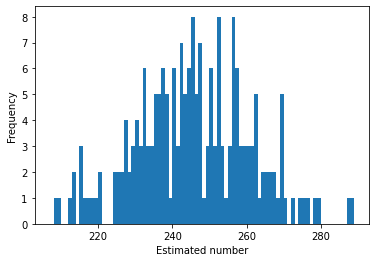

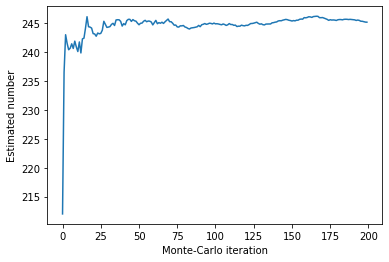

In [22]:
company=3         # must be in INTEGER
unit_type='C' # STRING
year=2022         # INTEGER
month=12           # INTEGER

Result_display(company,unit_type,year,month)

<ipython-input-20-f08ac3bda90f>:14: UserWarning: Kaplan-Meier model of type B data can not estimate the stock until that day. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of type {} data can not estimate the stock until that day. We apply the best parametric model to predict in this case.".format(str(typ)))


There are 39/43 units of type B of company 3 that is not failed at the moment.
Estimated number of type B unit in stock for company 3 from 12/2020 until 6/2030: 54.13
with confidence interval (46.00,64.00) and confidence interval in average (53.38,54.88) at level 95.00%.


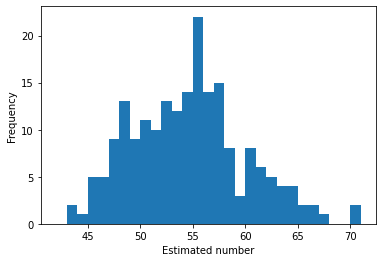

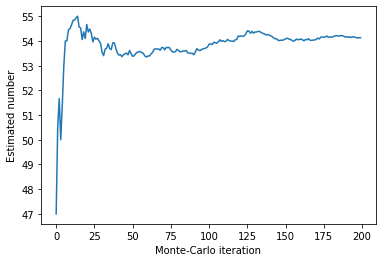

In [23]:
company=3         # must be in INTEGER
unit_type='B' # STRING
year=2030         # INTEGER
month=6           # INTEGER

Result_display(company,unit_type,year,month)

<ipython-input-20-f08ac3bda90f>:14: UserWarning: Kaplan-Meier model of type C-new data can not estimate the stock until that day. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of type {} data can not estimate the stock until that day. We apply the best parametric model to predict in this case.".format(str(typ)))
<ipython-input-14-1c412288dc8f>:9: UserWarning: There are more 90% censored data in type C-new data. The applied model might not be correct!
  warnings.warn("There are more 90% censored data in type {} data. The applied model might not be correct!".format(str(typ)))


There are 835/883 units of type C-new of company 3 that is not failed at the moment.
Estimated number of type C-new unit in stock for company 3 from 12/2020 until 6/2030: 838.115
with confidence interval (836.00,841.05) and confidence interval in average (837.87,838.36) at level 95.00%.


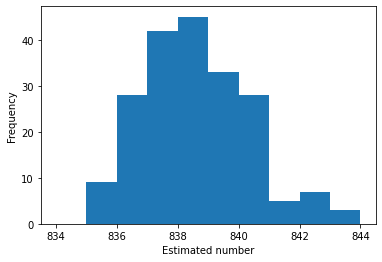

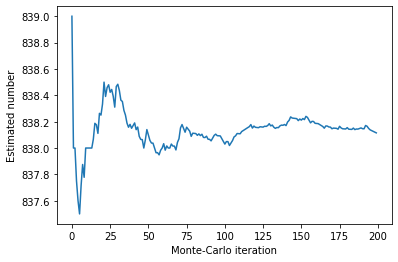

In [24]:
company=3         # must be in INTEGER
unit_type='C-new' # STRING
year=2030         # INTEGER
month=6           # INTEGER

Result_display(company,unit_type,year,month)

## IV. Test-Validation:

In [25]:
file_test = "./Datatest_until_Dec-2018.xlsx"
# "./INSA-Airbus FHS - Data set PN_C Dec-18.xlsx"
combined_test, air_test = preprocessing(file_test)
types_test = pd.unique(combined_test["PN"])
types_test = types_test[np.logical_not(pd.isnull(types_test))]
print("Unit types :",types_test)
combined_test.head()

Unit types : ['C' 'B' 'A' 'C-new']


,Company,PN,SN,TSI,TSN,failed
0,3,C,15323054356,5819.0,5819.0,True
1,3,C,15323057041,5819.0,5819.0,True
2,3,C,15323072973,3036.0,3036.0,True
3,3,C,15323053425,5614.0,5614.0,True
4,3,C,15323058236,5614.0,5614.0,True


In [26]:
print(len(set(combined_test['SN'])),'/',len(combined_test), 'distinct SN.')

5624 / 7001 distinct SN.


In [27]:
data_test = combined_test.copy()
data_test_types = {}
for typ in types_test:
    data_test_types[typ] = data_test[data_test['PN']==typ]

In [28]:
air_test

,Company,Number of aircraft,FH per aircraft per month,End of contract
0,1,6,415,2024-12-01
1,2,2,310,2030-12-01
2,3,12,350,2026-12-01
3,4,5,240,2023-12-01
4,5,19,375,2026-12-01
5,6,6,350,2027-12-01


There are 1130/1336 units of type A of company 5 that is not failed at the moment.
Estimated number of type A unit in stock for company 5 from 12/2018 until 12/2020: 72.99
with confidence interval (61.00,85.00) and confidence interval in average (71.94,74.04) at level 95.00%.


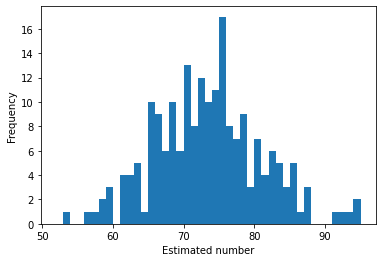

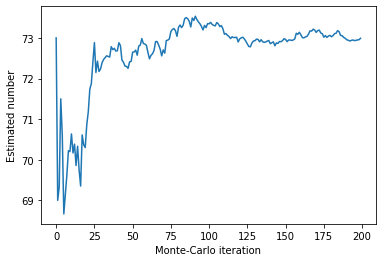

In [29]:
company=5         # must be in INTEGER
unit_type='A' # STRING
year=2020         # INTEGER
month=12           # INTEGER

date_test = dt.datetime(2018,12,1)
Result_display(company,unit_type,year,month,df=data_test,df_types=data_test_types,airlines=air_test,Begin=date_test)

In [30]:
table_18 = data_test[data_test.PN=='A']
table_18 = table_18[table_18.Company==5]
table_18 = table_18[table_18.failed==True]
print("Number of fail in 2018 : ", len(table_18))

Number of fail in 2018 :  206


In [31]:
table_20 = data[data.PN=='A']
table_20 = table_20[table_20.Company==5]
table_20 = table_20[table_20.failed==True]
print("Number of fail in 2020 : ", len(table_20))

Number of fail in 2020 :  271


In [32]:
print("Number of fail from 12/2018 to 12/2020 in reality : ",len(table_20)-len(table_18))

Number of fail from 12/2018 to 12/2020 in reality :  65


Test model using Kolmogorov-Smirnov, Kramer-von Mise

In [33]:
# def weib_R(x, alpha, beta):
#     return np.exp(-np.power(x/alpha, beta))

# def expo_R(x, lamb):
#     return np.exp(-1/lamb*x)

# def lognor_R(x, mu, std):
#     return 1-lognorm.cdf(x,std)

# def KStest(kap_meier, R, **args):
#     x1 = kap_meier.timeline
#     y1 = kap_meier.survival_function_.to_numpy().reshape((len(x1)))
#     y2 = R(x1, **args)
#     stat = np.max(np.abs(y1-y2))
#     prob = distributions.kstwobign.sf(stat*np.sqrt(len(x1)))
#     return stat, prob

# class cvm_unif_gen(rv_continuous):
#     def _argcheck(self, samples):
#         return samples > 0

#     @vectorize(otypes=(float,))
#     def _cdf(self, statistic, samples):
#         low = 1 / (12 * samples)
#         # Basic bounds.
#         if statistic <= low:
#             return 0.
#         if statistic >= samples / 3:
#             return 1.
#         # From the geometric approach of Csorgo and Faraway.
#         if statistic <= low + 1 / (4 * samples ** 2):
#             return (gamma(samples + 1) / gamma(samples / 2 + 1) *
#                                     (pi * (statistic - low)) ** (samples / 2))
#         # Asymptotic distribution with a one-term correction.
#         return cvm_unif_inf(statistic) + cvm_unif_fix1(statistic) / samples


# cvm_unif = cvm_unif_gen(a=0, name='cvm-unif', shapes='samples')

# inf_ks41 = 4 * arange(11) + 1
# inf_args = inf_ks41 ** 2 / 16
# inf_cs = (inf_ks41 ** .5 * gamma(varange(.5, 11)) /
#                                         (pi ** 1.5 * gamma(varange(1, 11))))


# def cvm_unif_inf(statistic):
#     """
#     Calculates the limiting distribution of the Cramer-von Mises statistic.

#     After the second line of equation 1.3 from the Csorgo and Faraway paper.
#     """
#     args = inf_args / statistic
#     return (inf_cs * exp(-args) * kv(.25, args)).sum() / statistic ** .5

# fix1_args = (4 * (varange((.5, 1., 1.5), 21)) - 1) ** 2 / 16
# fix1_dens = 72 * pi ** 1.5 * gamma(varange(1, 21))
# fix1_csa = fix1_args ** .75 * gamma(varange(1.5, 21)) / fix1_dens
# fix1_csb = fix1_args ** 1.25 * gamma(varange((.5, 1.5, 2.5), 21)) / fix1_dens


# def cvm_unif_fix1(statistic):
#     """
#     Approximates the first-term of the small sample count Gotze expansion.

#     After equation 1.10 (with coefficients pulled out as csa / csb).
#     """
#     args = fix1_args / statistic
#     kvs = kv((.25, .75, 1.25), args[:, :, newaxis])
#     gs, hs = exp(-args) * tensordot(((1, 1, 0), (2, 3, -1)), kvs, axes=(1, 2))
#     a = dot((7, 16, 7), fix1_csa * gs).sum() / statistic ** 1.5
#     b = dot((1, 0, 24), fix1_csb * hs).sum() / statistic ** 2.5
#     return cvm_unif_inf(statistic) / 12 - a - b
    
# def CVMtest(kap_meier, R, **args):
#     x1 = kap_meier.timeline
#     n = len(x1)
#     y1 = kap_meier.survival_function_.to_numpy().reshape((n))
#     y2 = np.linspace(1, np.min(y1), n)
#     y3 = R(x1, **args)

#     stat = 1/(12*n) + ((y3-y2)**2).sum()
#     p_valeur = cvm_unif(n).sf(stat)
#     return stat, p_valeur

In [34]:
# # exponential
# T = 10 # time T : end of contract
# lamb = models('B')[dict_model['Exponential']].lambda_ # parameter of exponential distribution
# SN_sim = combined[combined["PN"]=="B"]
# print(len(np.unique(SN_sim["SN"])))

# rand_draw_func = np.random.exponential

# def num_of_fails_indivi(TSI, T, rand_draw_func, **args):
#     n_fails = -1 # once the algo enter the loop, n_fails is at least 1
#     sum_t = 0
#     while sum_t <= T:
#         t = rand_draw_func(**args)
#         sum_t += t
#         n_fails += 1
#     return n_fails

# def num_of_fails_list(TSI_list, T, rand_draw_func, **args):
#     n_fails_list = []
#     for TSI in TSI_list:
#         n_fails = num_of_fails_indivi(TSI, T, rand_draw_func, **args)
#         n_fails_list += [n_fails]
#     total_fails = np.sum(n_fails_list)
#     return total_fails


